# DM Direct detection with NREFT operators (Mass-coupling dedicated study)

> **Project:** Direct Detection and Astrophysics

> **Description:** This file generate constraint and signal contours in the most standard mass-coupling space. We check the use of the Swordfish module by comparing the constraints generated from it with another independent method (maximum gap). We also compare with the XENON1T official result by showing our result in cross-section, as opposed to in model coupling as we have done in our paper.

> **Author:** John Shing Chau Leung

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import division    #for division operator
import swordfish as sf
import math, numpy as np
from astropy import constants as const
from astropy import units as u
from astropy import coordinates as coord
from scipy.special import erf, spherical_jn, factorial
from scipy.integrate import quad, odeint, simps, nquad
import scipy.stats as stats
from scipy.interpolate import interp1d, interp2d, InterpolatedUnivariateSpline, griddata
import matplotlib.pylab as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.transforms import Bbox
import warnings

from time import sleep
from tqdm import tqdm

import h5py
from sklearn import svm
from scipy.linalg import eig, eigvals
from random import randint
from itertools import cycle
import h5py
from sklearn.linear_model import Ridge
from sklearn.neighbors import BallTree
from scipy import interpolate

import swordfish as sf
from scipy.constants import c
from numpy.random import multivariate_normal
from matplotlib import rc
from scipy.interpolate import UnivariateSpline

import sys

sys.path.insert(0, "/Users/john/Desktop/direct_detection/code")

import operators as ops
import astrophys as fv

plt.style.use('seaborn-bright')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100

fmtoInverseGeV= 1.0/0.197
AMUtoGeV= 0.93146
mProton= 0.938   #in GeV
mNeutron= 0.9396 #in GeV
GFermi = 1.166E-5     #in GeV^(-2)
keVtoGeV= 1e-6 
invVelToUnitless = 3.0E5
SHM_sig_color = 'darkcyan'
Gaia_sig_color = 'coral'
SHM_excl_style = 'solid'
Gaia_excl_style = 'dashed'
excl_1T_color = 'gold'
excl_Da_color = 'indigo'

/Users/john/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load astrophysics data required to calculate cross-section. Generate the velocity moment functions.

In [2]:
operators = ops.Operator(1,1)

generating default halo


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]


generating SHM


100%|██████████| 100/100 [00:11<00:00,  9.02it/s]


generating default halo


100%|██████████| 100/100 [00:10<00:00,  9.10it/s]


generating SHM


100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


generating NLB full substructure


100%|██████████| 100/100 [00:13<00:00,  7.67it/s]


generating NLB full halo


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


Setting up and loading detector data. This includes

- the exposure

- the acceptance. We use that of XENON1T as the bench mark scenario (shown as in the plot)

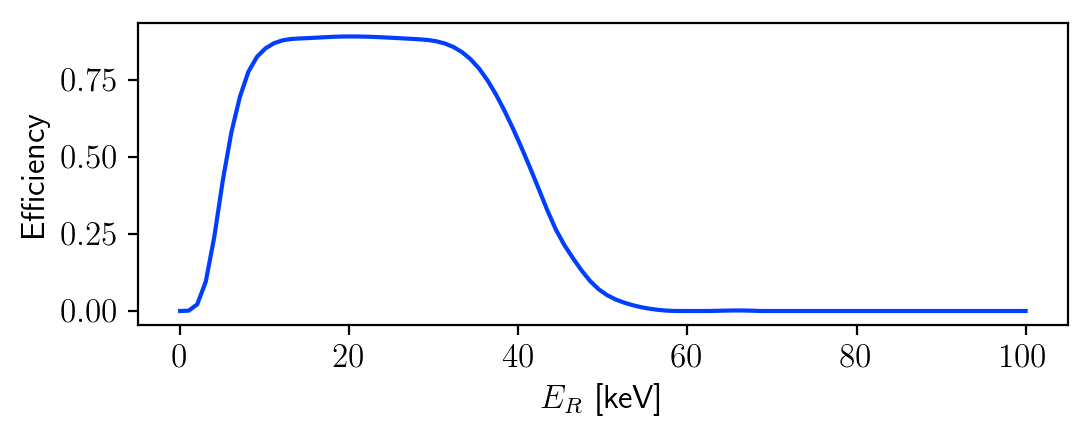

In [3]:
fileDirectory = "contour_data/"
plt.rcParams["figure.figsize"] = (6, 2)

Xe1T_keV, Xe1T_eff = np.loadtxt(fileDirectory+"efficiency_firstdata.csv", unpack=True, usecols=(0,1), skiprows=1, delimiter=',')
Xe1T_eff_curve = interp1d(Xe1T_keV, Xe1T_eff, bounds_error = False, fill_value = (0, 0) , kind='linear')
plt.plot(np.linspace(0,100,100), Xe1T_eff_curve(np.linspace(0,100,100)));
plt.xlabel(r"$E_R$ [keV]"); plt.ylabel(r"Efficiency"); plt.show();

def exposure_func(experiment): #kg days
    if (experiment =='CDMS'):
        return 1009.8
    if (experiment =='Xenon_1T'):
        return 362440.
    if (experiment =='Xenon_nT'):
        return 365000.*20.
    if (experiment =='Xenon_Darwin'):
        return 365000.*200.
    if (experiment =='Darkside_50'):
        return 365000*0.011
    if (experiment =='Darkside_20k'):
        return 365000*100

def accept_func(ER, experiment):
    #ER in GeV; 
    if (experiment =='CDMS'):
        return (ER < 20.)*(0.32 + 0.007*(ER - 20.))\
            + (ER >= 20.)*(0.25 - (0.07/80.)*(ER - 100.))
    if (experiment =='Xenon_1T'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Xenon_nT'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Xenon_Darwin'):
        return Xe1T_eff_curve(ER)*0.5
    if (experiment =='Darkside_50'):
        return np.ones_like(ER)*0.5
    if (experiment =='Darkside_20k'):
        return np.ones_like(ER)*0.5

## define the recoil spectrum function

The recoil function for NREFT operators, $\frac{\mathrm{d}R_T}{\mathrm{d}E_R}$.
> **dRT_DER(ER, mDM, coup, med, experiment, acceptance, v_funct)**
> - ER: recoil energy in keV
> - mDM: dark matter mass in GeV
> - coup: coupling constant (g)
> - med: type of interaction
> - experiment: name of the experment
> - acceptance: Boolean for using acceptance function or not
> - v_funct: name of the DM velocity distribution model

**dRT_dER_Model** accepts models and functions the same as **dRT_DER**

In [4]:
min_mass = 5.0
max_mass = 10**3.5
grid_mass_pts = 100
grid_sigma_pts = 100

def velDM_min(ER, mT, muT):
    return np.sqrt(mT*ER/(2*pow(muT, 2)))*invVelToUnitless

def dRT_dER(ER, mDM, coup, med, experiment, v_funct, acceptance=True):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV

    rhoDM= 0.3  #local DM density in GeV/cm^3

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.
        
    op_num_div = int(len(med[1:])/2)+1
    op_num_a = int(med[1:op_num_div])
    op_num_b = int(med[op_num_div:])
    
    #nuc_form_fac = F_funct(op_num_a, op_num_b, ER, v_min, mu_T=muT, nu=target, v_funct=v_funct)#*invVelToUnitless
    nuc_form_fac =  operators.F_funct(op_num_a, op_num_b, ER, v_min, mu_T=muT, med=med[0], nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f

def dRT_dER_Model(ER, mDM, coup, med, experiment, v_funct, acceptance=True):
    #ER and masses in GeV; as a default couplings are set to 1 in appropriate powers of GeV

    rhoDM= 0.3  #local DM density in GeV/cm^3

    if (experiment.split('_')[0] == 'CDMS'):
        target= '72Ge'
    elif (experiment.split('_')[0] == 'Xenon'):
        target= '131Xe'
    elif (experiment.split('_')[0] == 'Darkside'):
        target= '40Ar'
    
    A = operators.A[target]

    ER_GeV = ER*keVtoGeV
    mT, muT= operators.mass_func(mDM, target)
    N_T= 6.05771E8/A #number of scattering centers per 1 kg of target
    v_min= velDM_min(ER_GeV, mT, muT)
    norm_fac = N_T*(mT/(2*np.pi))*pow(coup, 2)*(rhoDM/mDM)
    
    if acceptance == True: 
        accept_f = accept_func(ER, experiment)
    else:
        accept_f = 1.

    #nuc_form_fac =  Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    nuc_form_fac =  operators.Model_funct(ER, v_min, mDM, mu_T=muT, med=med, nu=target, v_funct=v_funct)
    return norm_fac*nuc_form_fac*accept_f

## NREFT recoil spectra

Showing the $E_R$ spectra for various NREFT operators. The first set of six plots shows heavy mediators, the second set shows those of light mediator. The orange curves represent the recoil spectra under _Gaia_ and the cyan represent under SHM.

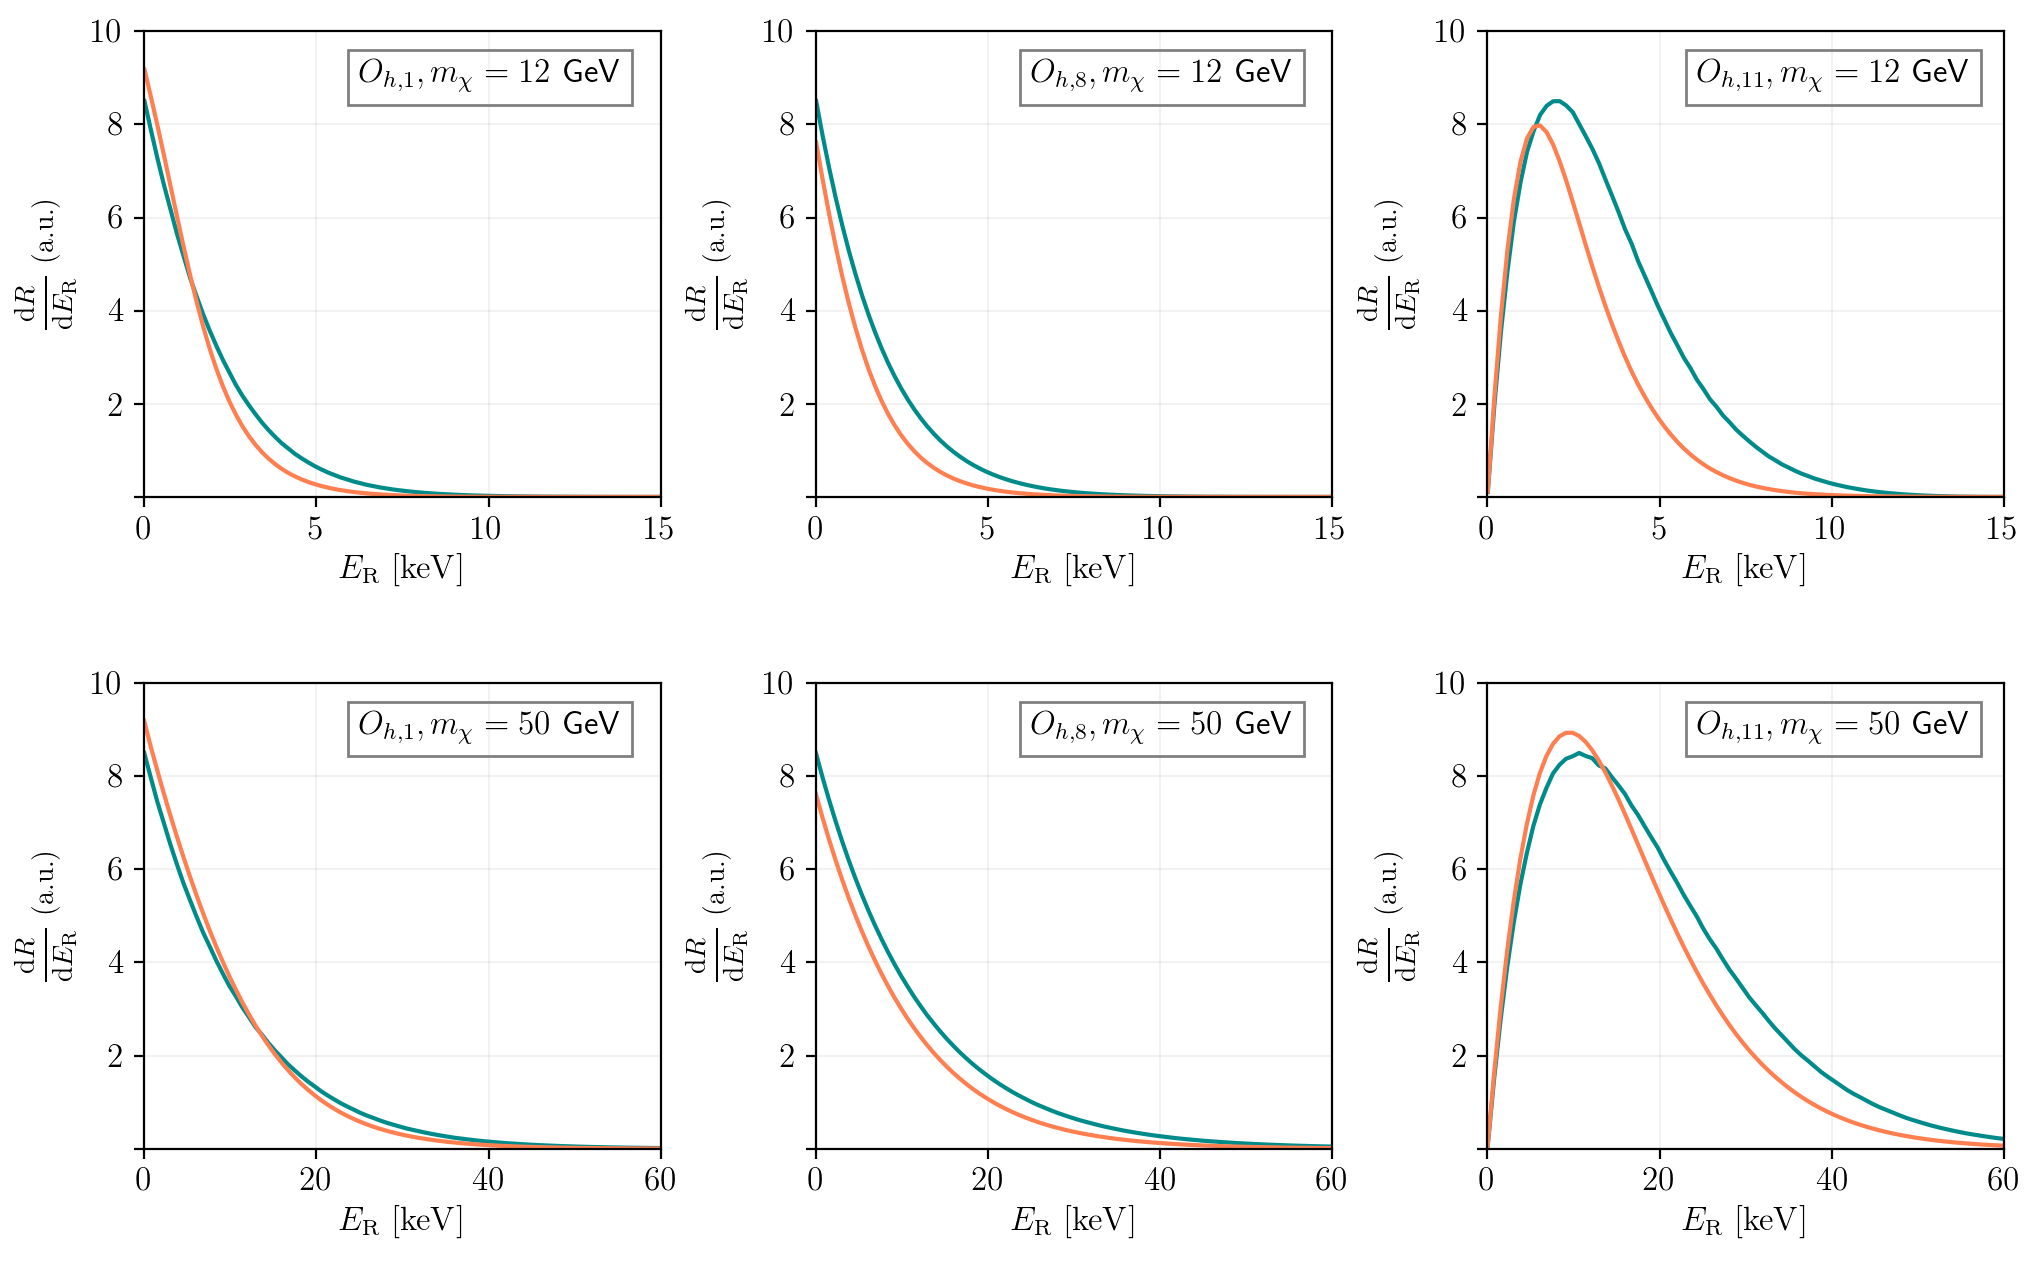

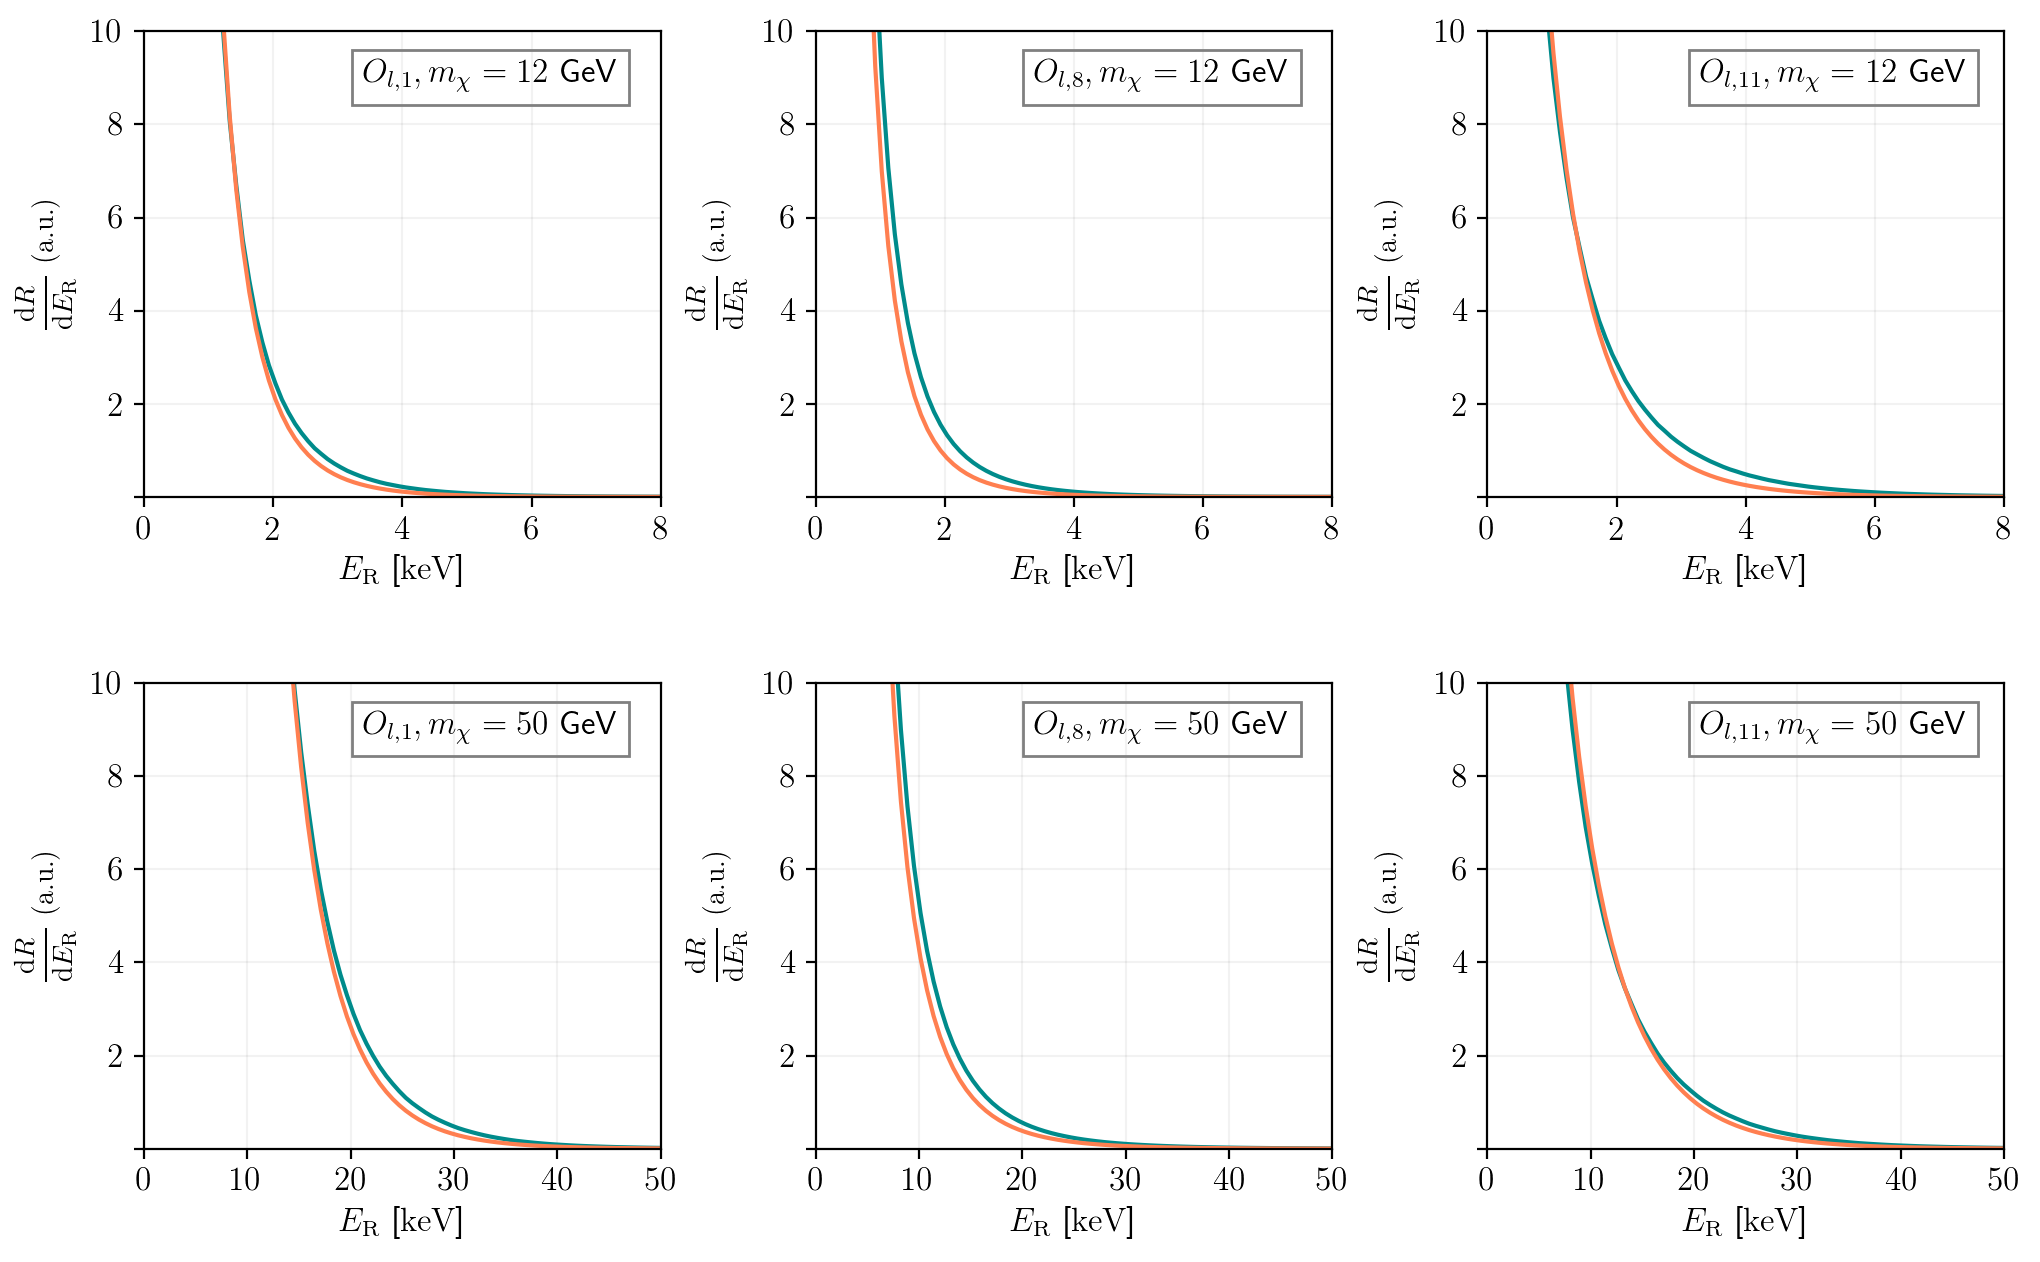

In [5]:
mass_L = 10**1.1; mass_H = 10**1.7
list_g_m_h = [['h11', mass_L],['h88', mass_L],['h1111', mass_L], \
            ['h11', mass_H],['h88', mass_H],['h1111', mass_H]]

num_col = 3; num_row = np.divide(len(list_g_m_h), num_col)

plt.rcParams["figure.figsize"] = (12, 3.7*num_row)
fig, ax= plt.subplots( num_row , num_col)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

ER_grid_H = np.linspace(0.01,60,80)
ER_grid_L = np.linspace(0.01,15,80)

for i_op, g_m in enumerate(list_g_m_h):
    k_col = np.mod(i_op, num_col); k_row = np.divide(i_op, num_col)
    oper = g_m[0]; mass_pt = g_m[1]; coup_pt = 10**-6.

    if mass_pt < 30:
        ER_grid = ER_grid_L; 
    else:
        ER_grid = ER_grid_H
    dER = ER_grid[1] - ER_grid[0]
        
    norm = 8.5/max(dRT_dER(ER_grid, mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER)
    
    ax[k_row, k_col].plot(ER_grid, norm*dRT_dER(ER_grid, mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER, color='darkcyan')
    ax[k_row, k_col].plot(ER_grid, norm*dRT_dER(ER_grid, mass_pt, coup_pt, oper, 'Xenon_1T', 'NLB_full', acceptance=False)*dER, color='coral')
    ax[k_row, k_col].set_xlabel(r'$E_{\rm R}\ [{\rm keV}]$');
    ax[k_row, k_col].set_ylabel(r'$\displaystyle\frac{\mathrm{d}R}{\mathrm{d}E_{\rm R}}\ ({\rm a.u.})$',fontsize=10);
    if len(g_m[0]) == 5:
        op_no = '11'
    else:
        op_no = oper[1]
    plot_title = r'$O_{%s, %s}, m_\chi = %d $ GeV' % (oper[0], op_no, int(mass_pt) )
    ax[k_row, k_col].text(.67,.88, plot_title, horizontalalignment='center', transform=ax[k_row, k_col].transAxes,
                         bbox=dict(facecolor='none', edgecolor='grey'))
    ax[k_row, k_col].set_ylim((0,10)), ax[k_row, k_col].set_xlim((0,max(ER_grid)))
    ax[k_row, k_col].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[k_row, k_col].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax[k_row, k_col].get_yticklabels()[0], visible=False)


fig.savefig('ER_spectra_H.pdf', bbox_inches = 'tight')
plt.show()

list_g_m_l = [['l11', mass_L],['l88', mass_L],['l1111', mass_L],\
                 ['l11', mass_H],['l88', mass_H],['l1111', mass_H]]

#---------------------------------------------------------------------------------------------

num_col = 3; num_row = np.divide(len(list_g_m_l), num_col)

plt.rcParams["figure.figsize"] = (12, 3.7*num_row)
fig, ax= plt.subplots( num_row , num_col)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

ER_grid_H = np.linspace(0.01,50,80)
ER_grid_L = np.linspace(0.01,8,80)

for i_op, g_m in enumerate(list_g_m_l):
    k_col = np.mod(i_op, num_col); k_row = np.divide(i_op, num_col)
    oper = g_m[0]; mass_pt = g_m[1]; coup_pt = 10**-6.

    if mass_pt < 30:
        ER_grid = ER_grid_L;
        norm = 9./(dRT_dER(ER_grid[np.divide(len(ER_grid),8)], mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER)
        if oper == 'l11':
            norm = 9./(dRT_dER(ER_grid[5*np.divide(len(ER_grid),14)], mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER)
    else:
        ER_grid = ER_grid_H
        norm = 9./(dRT_dER(ER_grid[np.divide(len(ER_grid),6)], mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER)
    dER = ER_grid[1] - ER_grid[0]
        
    
    ax[k_row, k_col].plot(ER_grid, norm*dRT_dER(ER_grid, mass_pt, coup_pt, oper, 'Xenon_1T', 'SHM', acceptance=False)*dER, color=SHM_sig_color)
    ax[k_row, k_col].plot(ER_grid, norm*dRT_dER(ER_grid, mass_pt, coup_pt, oper, 'Xenon_1T', 'NLB_full', acceptance=False)*dER, color=Gaia_sig_color)
    ax[k_row, k_col].set_xlabel(r'$E_{\rm R}$\ [{\rm keV}]');
    ax[k_row, k_col].set_ylabel(r'$\displaystyle\frac{\mathrm{d}R}{\mathrm{d}E_{\rm R}}\ ({\rm a.u.})$',fontsize=10);
    if len(g_m[0]) == 5:
        op_no = '11'
    else:
        op_no = oper[1]
    plot_title = r'$O_{%s, %s}, m_\chi = %d $ GeV' % (oper[0], op_no, int(mass_pt) )
    ax[k_row, k_col].text(.67,.88, plot_title, horizontalalignment='center', transform=ax[k_row, k_col].transAxes, 
        bbox=dict(facecolor='none', edgecolor='grey'))
    ax[k_row, k_col].set_ylim((0,10)), ax[k_row, k_col].set_xlim((0,max(ER_grid)))
    ax[k_row, k_col].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[k_row, k_col].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax[k_row, k_col].get_yticklabels()[0], visible=False)

    
fig.savefig('ER_spectra_L.pdf', bbox_inches = 'tight')
plt.show()

# Result analysis

## Cross-checking exclusion contour

In this section, we cross-check our result by using two different methods to general to 90% CL exclusion. The first method is the maximum gap method (S. Yellin, physics/0203002) and the equivalent count method (T.D.P. Edwards and C. Weniger, 1712.05401) from the <a href=https://github.com/cweniger/swordfish>Swordfish</a> module. We expect matching up to factor of a couple.

First of all we load up the S1 background from 1705.06655 and convert it to $E_R$ space. 

Here we are define the **elc_moment** and **mag_moment** that convert the coupling (g) in unit of GeV to units of electric dipole moment (e cm) and electron Bohr magneton ($\mu_e$).

In [6]:
ER_grid = np.linspace(5.,40.,80)
dER = ER_grid[1] - ER_grid[0]
exposure_2017 = 35636.

s1 = np.linspace(3,70,num=20)
s1width = s1[1]-s1[0]
s1means = s1[0:-1]+s1width/2.
bkgs = ['acc','Anom','ElectronRecoil','n','Neutrino','Wall']


eff1, eff2 = np.loadtxt("./Swordfish_Xenon1T/Efficiency-1705.06655.txt", unpack=True)
efficiency = UnivariateSpline(eff1, eff2, ext="zeros", k=1, s=0)
S1_vals, E_vals = np.loadtxt("./Swordfish_Xenon1T/S1vsER.txt", unpack=True)
CalcER = UnivariateSpline(S1_vals, E_vals, k=5, s=0)
dERdS1 = CalcER.derivative()
CalcS1 = UnivariateSpline(E_vals, S1_vals, k=5, s=0)
dS1dER = CalcER.derivative()

bkg = np.zeros_like(s1means)
for i in range(len(bkgs)):
    S1, temp = np.loadtxt("./DD_files/" + bkgs[i] + ".txt", unpack=True)
    interp = interp1d(S1, temp, bounds_error=False, fill_value=0.0)
    #b[bkgs[i]] = interp(s1means)
    bkg  = bkg + interp(s1means)
bkg_f = interp1d(s1means, bkg, bounds_error=False, fill_value=0.0)
bkg_ER = interp1d(ER_grid, dS1dER(ER_grid)*bkg_f(CalcS1(ER_grid))/exposure_2017)


GeVtoInvcm = 5.06*(10**13); e_charge = np.sqrt(4.*np.pi/137.); e_mass = 511.*(10**(-6))

def elc_moment(g_energy, log_coup = False, log_out = False):
    if log_coup:
        g_energy = 10**g_energy
    if log_out :
        return np.log10(e_charge*g_energy/GeVtoInvcm)
    return e_charge*g_energy/GeVtoInvcm
def mag_moment(g_energy, log_coup = False, log_out = False):
    if log_coup:
        g_energy = 10**g_energy
    if log_out :
        return np.log10(g_energy*2*e_mass/e_charge)
    return g_energy*2*e_mass/e_charge

### Maximum gap method

Defining the maximum gap method. In the first block we define the "signal gaps" in keV that is used to evaluate the Poisson statistics.

In the second block, we define functions that generate the exclusion contours

   > - **counts_func** returns the total count of a recoil spectrum by integrating between *ER_min* and *ER_max*.
   > - **max_gap_tot_counts_func** return a 2-tuple, the first entry is the count within the maximum gap; the second entry is the count of the whole $E_R$ interval in consideration. This function automatically loads the corresponding **intervals_func** according to the *experiment* argument.
   > - **C0_func** the mathematical $C_0$ function defined in physics/0203002.
   > - **exclusion_contour(len_sigma_grid, len_mdm_grid, med, experiment, v_funct)** returns a 3-tuple of three arrays of the same dimension/length. The first entry is the $C_0$ value, the second is the DM mass grid, the third is the coupling strength grid. *len_sigma_grid* and *len_mdm_grid* arguments are the number of points in the coupling and mass grids respectively.

In [7]:
def intervals_func(experiment):
    if (experiment == 'CDMS'):
        return np.array([[12.3, 15.5], [15.5, 100.0]])
    if (experiment == 'Xenon_1T'):
        return np.array([[5.0, 40.]]) #np.array([[4.9, 40.9]])
    if (experiment == 'Xenon_nT'):
        return np.array([[5.0, 40.]]) #np.array([[4.9, 40.9]])
    if (experiment == 'Xenon_Darwin'):
        return np.array([[5.0, 40.]]) #np.array([[4.9, 40.9]])
    if (experiment == 'Darkside_50'):
        return np.array([[0.6, 200.]])
    if (experiment == 'Darkside_20k'):
        return np.array([[0.6, 200.]])

In [8]:
def counts_func(ER_min, ER_max, mDM, coup, med, spin='SI', steps=100, experiment=None, v_funct='default'):
    #for calculating total counts and maximum gap; ER in keV
    
    exposure= exposure_func(experiment)
    ER_array= np.linspace(ER_min, ER_max, steps)
    dER = ER_array[1] - ER_array[0]
    
    if opers[0] != 'h' or opers[0] != 'l':
        rec_rate_array= [dER*exposure*dRT_dER_Model(x, mDM, coup, med, experiment, acceptance=True, v_funct=v_funct) for x in ER_array]
    else :
        rec_rate_array= [dER*exposure*dRT_dER(x, mDM, coup, med, experiment, acceptance=True, v_funct=v_funct) for x in ER_array]
        
    return simps(rec_rate_array, ER_array)

def max_gap_tot_counts_func(mDM, coup, med, spin='SI', steps=100, experiment=None, v_funct='default'):
    
    exp_intervals= intervals_func(experiment)
    tot_counts= 0
    max_gap= 0

    for i in xrange(len(exp_intervals)):
        temp_count= counts_func(exp_intervals[i, 0], exp_intervals[i, 1], mDM, coup, med, spin, \
                                experiment=experiment, v_funct=v_funct)
        tot_counts+= temp_count
        if (temp_count > max_gap):
            max_gap= temp_count
    
    return max_gap, tot_counts

def C0_func(x, mu):
    #maximum gap probability distribution following S. Yellin phyiscs/0203002

    if (mu <= 0) or (x == 0.):
        if (x < 1):
            return 0.0
        else:
            return 1.0
    elif (x > mu):
        return 1.0
    elif ((x< 0.03*mu and mu< 60.0) or (x < 1.8 and mu >= 60.0) or (x < 4.0 and mu >= 700.0)):
        return 0.0
    elif (x != mu):
        lim= np.int(math.floor(mu/x))
        return np.sum([pow((k*x - mu), k-1)*np.exp(-k*x)*(k*x - mu - k)/math.factorial(k) for k in xrange(0, lim+1)]) 
        #factorials over 170 don't like being converted to float; so might want to add an extra if condition 
    else:
        lim= np.int(math.floor(mu/x))
        return 1 - np.exp(-x) + np.sum([pow((k*x - mu), k-1)*np.exp(-k*x)*(k*x - mu - k)/math.factorial(k) for k in xrange(2, lim+1)])
    
    
    
def exclusion_contour(len_sigma_grid, len_mdm_grid, med, experiment, v_funct):
    #function for plotting exclusion curve in DM coupling-mass space
    
    low_sigma, high_sigma = operators.get_xsec_lim(med)
        
    log_sigma_grid= np.linspace(low_sigma, high_sigma, len_sigma_grid)
    log_mDM_grid= np.linspace(np.log10(min_mass), np.log10(max_mass), len_mdm_grid)
        
    max_gap_tot_events_grid= np.array([[max_gap_tot_counts_func(mDM= i_entry, coup= j_entry,\
                                            med=med, experiment=experiment,v_funct=v_funct) \
                                     for i_entry in (10.**log_mDM_grid)] for j_entry in (10.**log_sigma_grid)])
    
    C0_grid= np.array([[C0_func(max_gap_tot_events_grid[j, i, 0], max_gap_tot_events_grid[j, i, 1]) 
                   for i, i_entry in enumerate(10**log_mDM_grid)] for j, j_entry in enumerate(10**log_sigma_grid)])
 
    return C0_grid, 10.**log_mDM_grid, 10**log_sigma_grid

## Equivalent count method

Define the equivalent count method that generates the CL contour in mass-coupling plane.

> **EC_upper_limit(ER, log_mDM_grid, med, experiment, v_funct, alpha)** returns a 2-tuple, the first entry is the coupling corresponding to the p-value $\alpha$; the second the corresponding DM mass.
> - *log_mDM_grid*: the mass grid in logrithm
> - *alpha*: the p-value corresponding to the CL

In [9]:
def EC_upper_limit(ER, log_mDM_grid, med, experiment, v_funct, alpha = 0.1):
    ULlist = []; mass_list_out = []
    dER = ER[1] - ER[0]
    exposure = np.ones_like(ER)*exposure_func(experiment)
    
    warnings.filterwarnings('error')
    
    B_null = np.ones_like(ER)*1e-30
    B_bkg = bkg_ER(ER)
    
    SF = sf.Swordfish([B_bkg+B_null], E=exposure)
    
    low_sigma, high_sigma = operators.get_xsec_lim(med)
    coup_ref = low_sigma
    
    
    for m in log_mDM_grid:
        try:
            if opers[0] != 'h' or opers[0] != 'l':
                dRdE = dRT_dER_Model(ER, 10**m, 10**coup_ref, med, experiment, v_funct, acceptance=True)*dER
            else:
                dRdE = dRT_dER(ER, 10**m, 10**coup_ref, med, experiment, v_funct, acceptance=True)*dER
            limit_pt = SF.upperlimit(dRdE, alpha)
            if limit_pt > 0:
                ULlist.append(limit_pt)
            else:
                continue
            mass_list_out.append(10**m)
        except:
            continue
    ULlist_coup = np.array(np.sqrt(ULlist)*(10**coup_ref))
    
    return ULlist_coup, mass_list_out

## Euclideanize signal method

The eclideanize signal method that generates the **signal** contours.

> **plot_ellipse(ax, sh, coupling_c0, coupling_c1, cm_plot, contour, ind)** returns a 2-tuple, the first entry is the coupling corresponding to the p-value $\alpha$; the second the corresponding DM mass.
> - *ax*: the axis object from matplotlib
> - *sh*: the SignalHandler object from Swordfish module
> - *coupling_c0*, *coupling_c1*: the value/array for x-axis, y-axis of the benchmark signal
> - *cm_plot*: the signal point/signal lattice
> - *contour*: specifies whether it is a SHM or _Gaia_ contour. This decorates the contour to one of the two predetermined colors.
> - *ind*: if _None_, it takes *cm_plot* as a single point value in the 2D space, which plots a single contour. If it is an integer, it takes *cm_plot* as a contour lattice, and plots the *ind*-th contour in the signal lattice.

In [10]:
def plot_ellipse(ax, sh, coupling_c0, coupling_c1, cm_plot, contour, ind = None):
    min_contour_pts = 4
    P0 = cm_plot
    if ind is not None:
        P0 = cm_plot[ind,:]
    
    if contour == 'SHM':
        color_c = SHM_sig_color
    elif contour == 'NLB':
        color_c = Gaia_sig_color
    pp2, el_ind2, d2 = sh.query_region(P0, sigma=3, d=2, return_distance = True)
    
    z = np.ones_like(coupling_c0[el_ind2])
    x = coupling_c0[el_ind2]
    y = coupling_c1[el_ind2]
    if len(z) < min_contour_pts:
        return
    try:
        ax.tricontour(x, y, d2, colors=[color_c, color_c], levels=[0, 1.5152])
        #ax.tricontourf(x, y, d2, colors=[color_c, color_c], levels=[0, 1.5152], alpha=0.05)
    except:
        return
    return


Define the **format_fig** function as a handle for quick figure formatting.

In [11]:
def format_fig(ax, x_string, y_string, x_label, y_label, log_log_in = False, log_log_out = False):
    
    ax.minorticks_on();
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax.get_yticklabels()[0], visible=False)
    
    if not log_log_out:
        ax.set_yscale('log')
        ax.set_xscale('log')
    
    xlim_down, xlim_up = ax.get_xlim()
    ylim_down, ylim_up = ax.get_ylim()
    
    def coup_scale(coup):
        if (log_log_in and log_log_out) or (not log_log_in and not log_log_out):
            return coup
        if (not log_log_in and log_log_out):
            return np.log10(coup)
        elif (log_log_in and not log_log_out):
            return 10**coup
    
    yaxsec = ax.twinx();
    xaxsec = ax.twiny();
    
    if not log_log_out:
        yaxsec.set_yscale('log')
        xaxsec.set_xscale('log')
    
    if x_string == 'mass':
        if not log_log_out:
            xaxsec.set_xlabel(r'$m_\chi\ [{\rm GeV}]$', fontsize=18);
        else :
            xaxsec.set_xlabel(r'$\log_{10}(m_\chi)\ [{\rm GeV}]$', fontsize=18);
        xaxsec.set_xlim( coup_scale(xlim_down), coup_scale(xlim_up) );
    elif x_string[:3] == 'mDM':
        xaxsec.set_xlim((  mag_moment(xlim_down, log_log_in, log_log_out), mag_moment(xlim_up, log_log_in, log_log_out) ))
        if x_string[-1] == 'l':
            xaxsec.set_xlabel(r'$\log_{10}(\mu_\chi)\ [\mu_e]$', fontsize=18);
        elif x_string[-1] == 'h':
            xaxsec.set_xlabel(r'$\log_{10}(\mu_\chi)\ [\mu_e{\rm GeV}^{-2}]$', fontsize=18);
    elif x_string[:3] == 'eDM':
        xaxsec.set_xlim( (elc_moment( xlim_down, log_log_in, log_log_out), elc_moment(xlim_up, log_log_in, log_log_out) ))
        if x_string[-1] == 'l':
            xaxsec.set_xlabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm})]$', fontsize=18);
        elif x_string[-1] == 'h':
            xaxsec.set_xlabel(r'$\log_{10}(d_\chi)\ [e\cdot\rm{cm}\cdot\rm{GeV}^{-2}]$', fontsize=18);
    elif x_string[:3] == 'mQ':
        xaxsec.set_xlim((  coup_scale(xlim_down), coup_scale(xlim_up) ))
        xaxsec.set_xlabel(r'$\log_{10}(\epsilon_\chi)$', fontsize=18)
    else:
        xaxsec.set_xlim((coup_scale(xlim_down), coup_scale(xlim_up) ))
        xaxsec.set_xlabel(x_label, fontsize=18);

    xaxsec.minorticks_on();
    xaxsec.tick_params(axis='both', which='major', labelsize=18)
    xaxsec.tick_params(axis='both', which='minor', labelsize=16)
    xaxsec.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    xaxsec.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(xaxsec.get_yticklabels()[0], visible=False)
    ax.xaxis = xaxsec.xaxis
    xaxsec.xaxis.set_label_position('bottom'); xaxsec.xaxis.set_ticks_position('bottom')
    
    if y_string[:3] == 'mDM':
        yaxsec.set_ylim(( mag_moment(ylim_down, log_log_in, log_log_out), mag_moment(ylim_up, log_log_in, log_log_out) ))
        if y_string[-1] == 'l':
            yaxsec.set_ylabel(r'$\log_{10}(\mu_\chi)\ [\mu_e]$', fontsize=18);
        elif y_string[-1] == 'h':
            yaxsec.set_ylabel(r'$\log_{10}(\mu_\chi)\ [\mu_e\cdot{\rm GeV}^{-2}]$', fontsize=18);
    elif y_string[:3] == 'eDM':
        yaxsec.set_ylim(( elc_moment(ylim_down, log_log_in, log_log_out), elc_moment(ylim_up, log_log_in, log_log_out) ))
        if y_string[-1] == 'l':
            yaxsec.set_ylabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm}]$', fontsize=18);
        elif y_string[-1] == 'h':
            yaxsec.set_ylabel(r'$\log_{10}(d_\chi)\ [e\cdot{\rm cm}\cdot{\rm GeV}^{-2}]$', fontsize=18);
    elif y_string[:3] == 'mQ':
        yaxsec.set_ylim((coup_scale(ylim_down), coup_scale(ylim_up) ))
        yaxsec.set_ylabel(r'$\log_{10}(\epsilon_\chi)$', fontsize=18)
    else:
        yaxsec.set_ylim((coup_scale(ylim_down), coup_scale(ylim_up) ))
        yaxsec.set_ylabel(y_label, fontsize=18);
        
    yaxsec.minorticks_on();
    yaxsec.tick_params(axis='both', which='major', labelsize=18)
    yaxsec.tick_params(axis='both', which='minor', labelsize=16)
    yaxsec.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    yaxsec.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(yaxsec.get_yticklabels()[0], visible=False)
    ax.yaxis = yaxsec.yaxis
    yaxsec.yaxis.set_label_position('left'); yaxsec.yaxis.set_ticks_position('left')
    
    return xaxsec, yaxsec

def full_extent(ax, pad=0.0):

    ax.figure.canvas.draw()
    items = [ax, ax.title, ax.xaxis.label, ax.yaxis.label, ax.get_xaxis().get_label(), ax.get_yaxis().get_label()]
    
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

Generate the maximum gap contours.

In [14]:
ops_list = ['SS', 'mQ','mDM_h','mDM_l']

interp_C0_grid_SHM_Xe = []
interp_C0_grid_SHM_Xe_20 = []
interp_C0_grid_SHM_Xe_Da = []
interp_C0_grid_NLB_Xe = []
interp_C0_grid_NLB_Xe_20 = []
interp_C0_grid_NLB_Xe_Da = []

for opers in tqdm(ops_list, desc="generating SHM XENON 1T contours") :
    interp_C0_grid_SHM_Xe.append( exclusion_contour(grid_sigma_pts, grid_mass_pts, opers, 'Xenon_1T', v_funct='SHM'))

for opers in  tqdm(ops_list, desc="generating SHM XENON Darwin contours") :
    interp_C0_grid_SHM_Xe_Da.append( exclusion_contour(grid_sigma_pts, grid_mass_pts, opers, 'Xenon_Darwin', v_funct='SHM'))

for opers in tqdm(ops_list, desc="generating NLB XENON 1T contours") :
    interp_C0_grid_NLB_Xe.append( exclusion_contour(grid_sigma_pts, grid_mass_pts, opers, 'Xenon_1T', v_funct='NLB_full'))
    
for opers in tqdm(ops_list, desc="generating NLB XENON Darwin contours") :
    interp_C0_grid_NLB_Xe_Da.append( exclusion_contour(grid_sigma_pts, grid_mass_pts, opers, 'Xenon_Darwin', v_funct='NLB_full'))

print "complete!"

generating NLB XENON Darwin contours: 100%|██████████| 4/4 [20:25<00:00, 306.48s/it]

complete!


## Upper limits validation

Plot maximum gap method alongside with equivalent count method for both the XENON1T and DARWIN experiments. The dashed lines represent maximum gap contours. The solid lines are equivalent count method. We expect $O(1)$ agreement with maybe a factor of a couple discrepancy due to the different assumptions made.

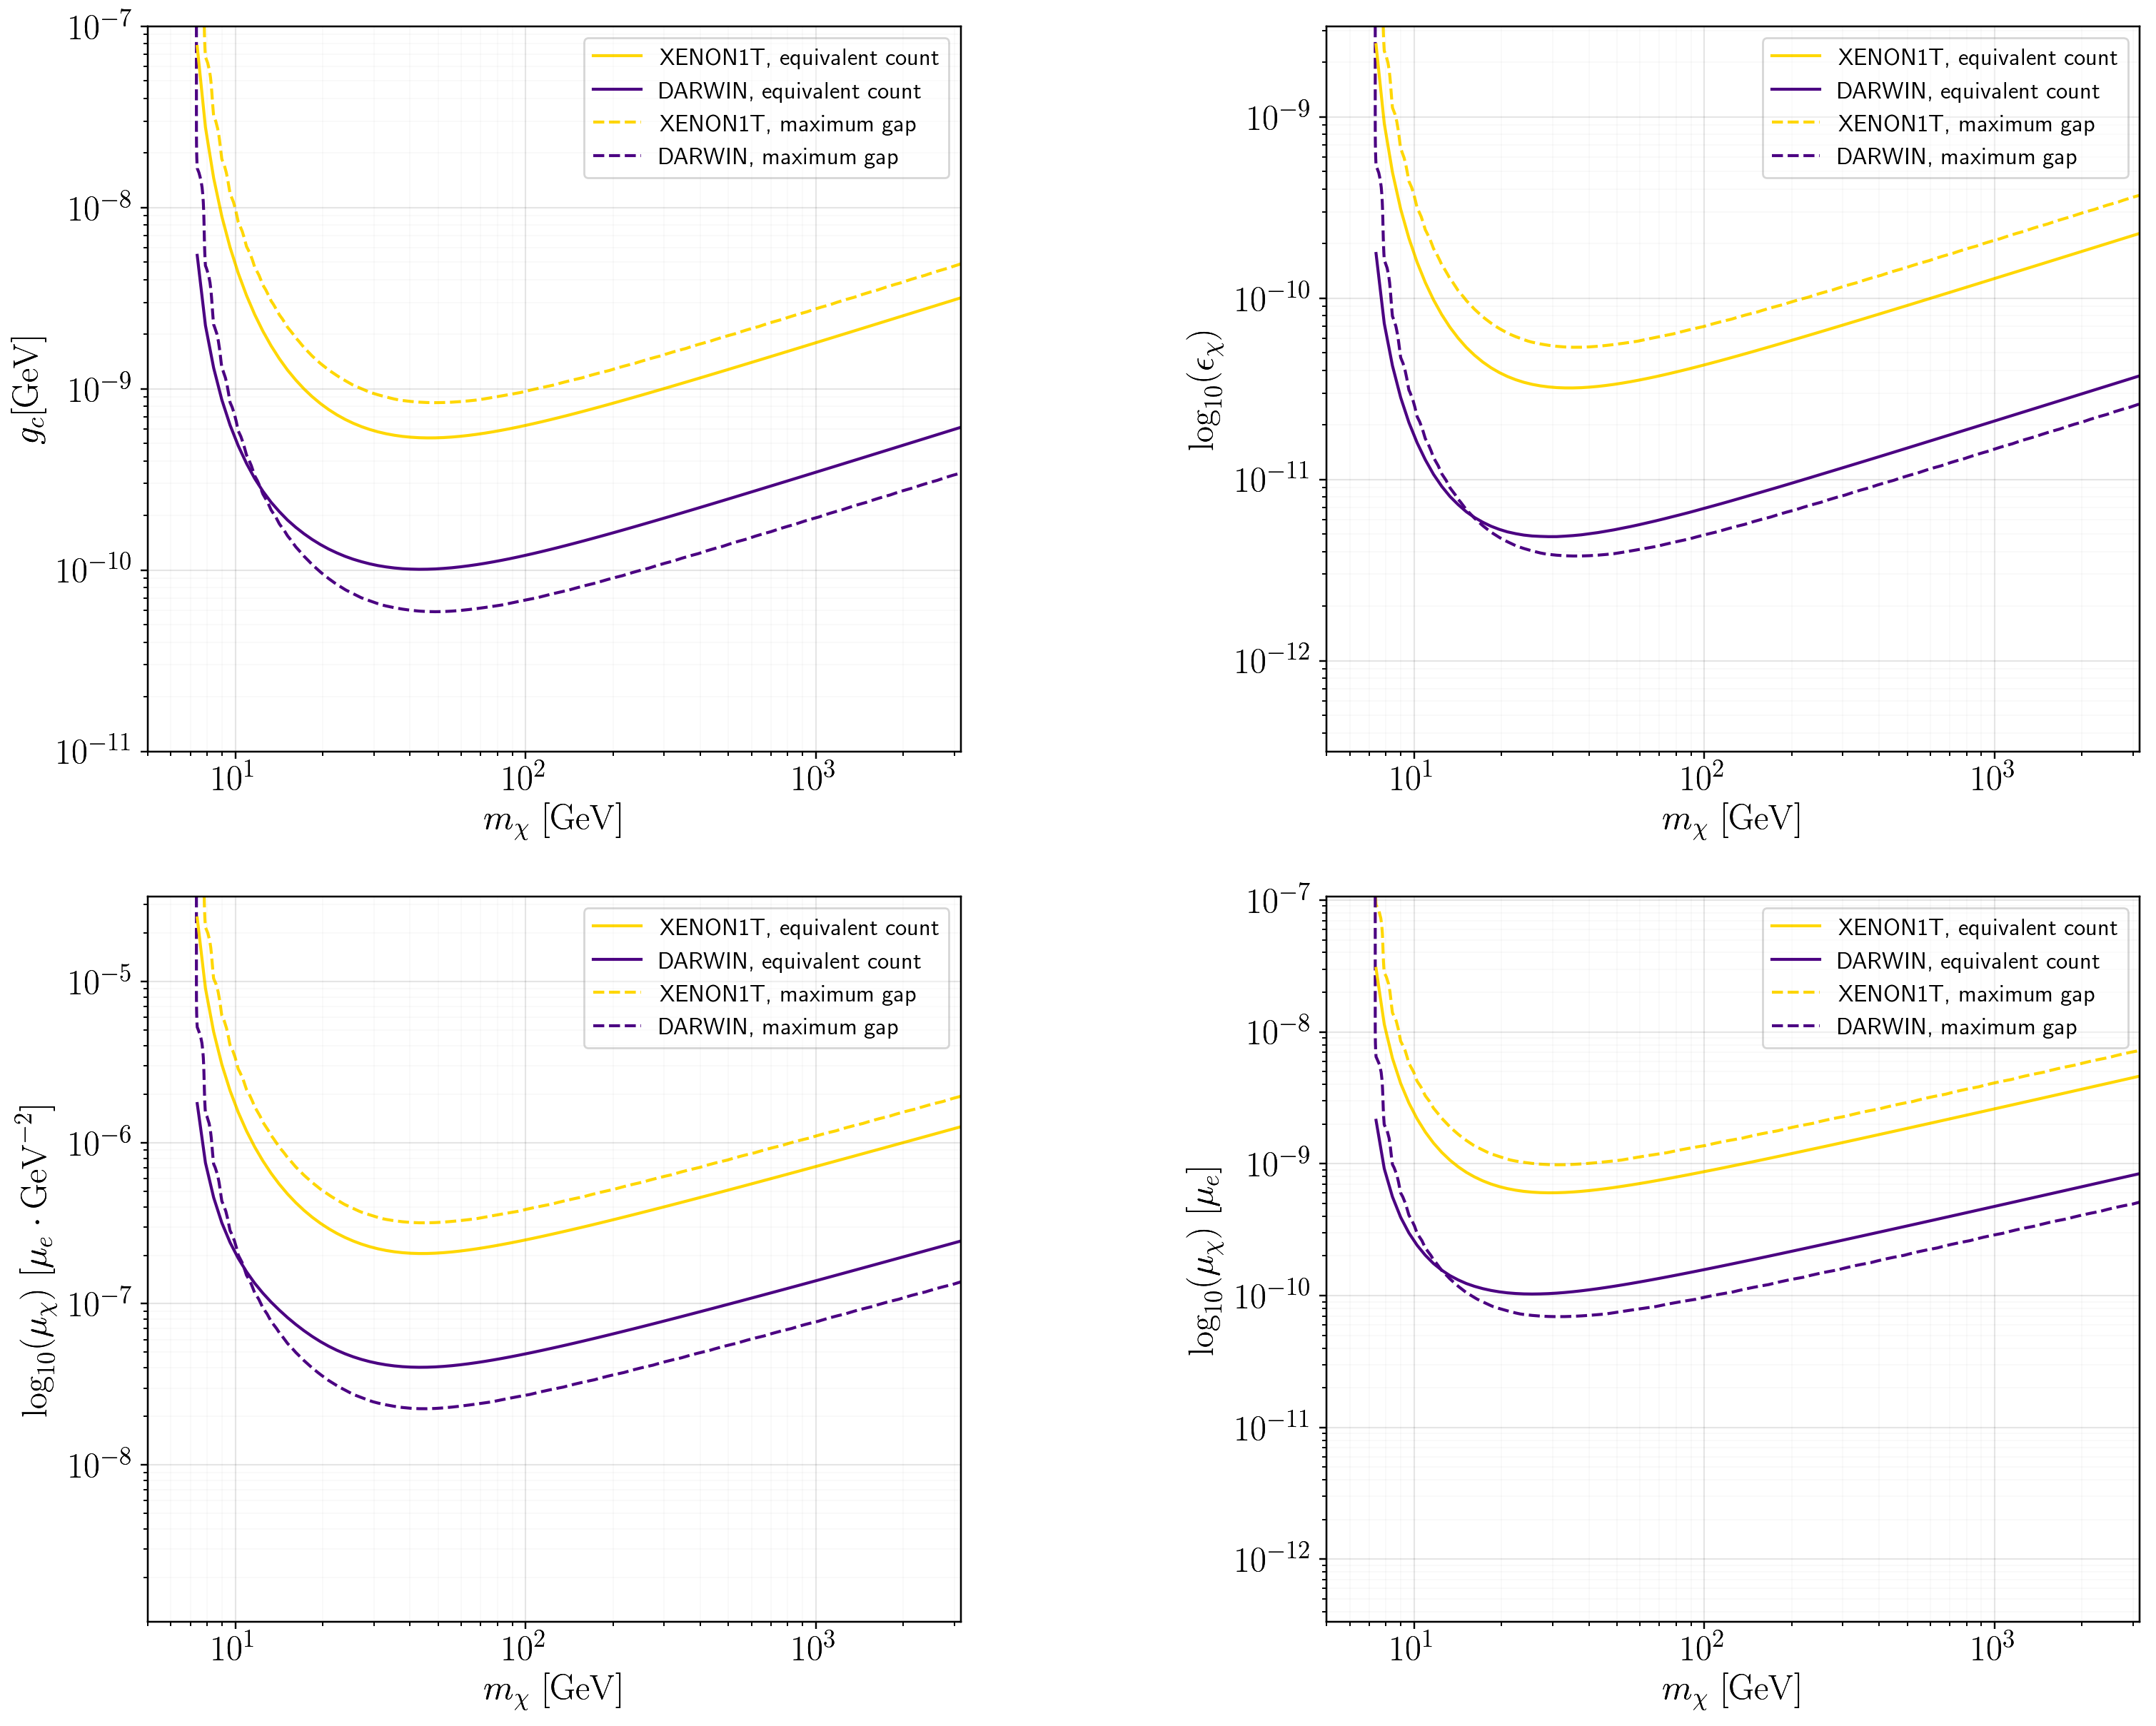

In [70]:
ops_list = ['SS', 'mQ','mDM_h','mDM_l']
eta = 0.42

plt.rcParams["figure.figsize"] = (18, 3.7*len(ops_list))
fig, ax= plt.subplots( int(np.ceil(len(ops_list)/2.)) , 2)
fig.subplots_adjust(wspace=0.45)

ER_grid = np.linspace(5,40,80)
log_mDM_grid = np.linspace(np.log10(min_mass), np.log10(max_mass), 100)

label_array = ['SHM', 'Xenon100T', 'NLB', 'NLB halo', 'NLB substructure']

for i_op, opers in enumerate(ops_list):
    plot_array = []; row_indx = np.divide(i_op, 2); col_indx = np.mod(i_op, 2)
    
    plot_array.append(ax[row_indx, col_indx].contour( interp_C0_grid_SHM_Xe[i_op][1], interp_C0_grid_SHM_Xe[i_op][2], \
                interp_C0_grid_SHM_Xe[i_op][0], levels=[0.9], colors=excl_1T_color, linestyles='--') )
    plot_array.append(ax[row_indx, col_indx].contour( interp_C0_grid_SHM_Xe_Da[i_op][1], interp_C0_grid_SHM_Xe_Da[i_op][2], \
                interp_C0_grid_SHM_Xe_Da[i_op][0], levels=[0.9], colors=excl_Da_color, linestyles='--') )
    #plot_array.append(ax[row_indx, col_indx].contour( interp_C0_grid_NLB_Xe[i_op][1], interp_C0_grid_NLB_Xe[i_op][2], \
    #            interp_C0_grid_NLB_Xe[i_op][0], levels=[0.9], alpha=0.6, colors='red', linestyles='solid', label='Gaia, Xenon 1T') )
    #plot_array.append(ax[row_indx, col_indx].contour( interp_C0_grid_NLB_Xe_100[i_op][1], interp_C0_grid_NLB_Xe_100[i_op][2], \
    #            interp_C0_grid_NLB_Xe_100[i_op][0], levels=[0.9], alpha=0.9, colors='red', linestyles='--', label='Gaia, Xenon nT') )
    plot_contours, plot_mass = EC_upper_limit(ER_grid, log_mDM_grid, opers, 'Xenon_1T', 'SHM')
    ax[row_indx, col_indx].plot(plot_mass, plot_contours, color=excl_1T_color, linestyle='solid', label='XENON1T, equivalent count')
    plot_contours, plot_mass = EC_upper_limit(ER_grid, log_mDM_grid, opers, 'Xenon_Darwin', 'SHM')
    ax[row_indx, col_indx].plot(plot_mass, plot_contours, color=excl_Da_color, linestyle='solid', label='DARWIN, equivalent count')
    ax[row_indx, col_indx].plot([0],[0], color=excl_1T_color, linestyle='--', label='XENON1T, maximum gap')
    ax[row_indx, col_indx].plot([0],[0], color=excl_Da_color, linestyle='--', label='DARWIN, maximum gap')
    ax[row_indx, col_indx].legend()
    
    format_fig(ax[row_indx, col_indx], 'mass', opers, None, r'$g_c [{\rm GeV}]$')

extent = full_extent(ax[0, 0]).transformed(fig.dpi_scale_trans.inverted())
fig.savefig('exclusion_scalarscalar.pdf', bbox_inches=extent.expanded(1.05,1.05))
extent = full_extent(ax[0, 1]).transformed(fig.dpi_scale_trans.inverted())
fig.savefig('exclusion_millicharge.pdf', bbox_inches=extent.expanded(1.05,1.05))
extent = full_extent(ax[1, 0]).transformed(fig.dpi_scale_trans.inverted())
fig.savefig('exclusionl_magneticDM_H.pdf', bbox_inches=extent.expanded(1.05,1.05))
extent = full_extent(ax[1, 1]).transformed(fig.dpi_scale_trans.inverted())
fig.savefig('exclusion_magneticDM_L.pdf', bbox_inches=extent.expanded(1.05,1.05))
plt.show()

## Upper limits in unit of cross-section

The proton cross-section is

$\sigma_p = \frac{g^2 \mu_p^2}{\pi}$,

where $\mu_p = \frac{m_p m_\chi}{m_p + m_\chi}$.

In [49]:
def xsec_func(log_g, m_DM):
    cmtoInverseGeV = (1e13)*fmtoInverseGeV
    mup = mProton*m_DM/(mProton+m_DM)
    xsec = (2*log_g) + 2*np.log10(mup)-2*np.log10(cmtoInverseGeV) - np.log10(np.pi)
    return xsec

Plotting constraints in cross-section ($\sigma$) as opposed to coupling (g). This is for the ease to compare with the official result from the DD experiments.

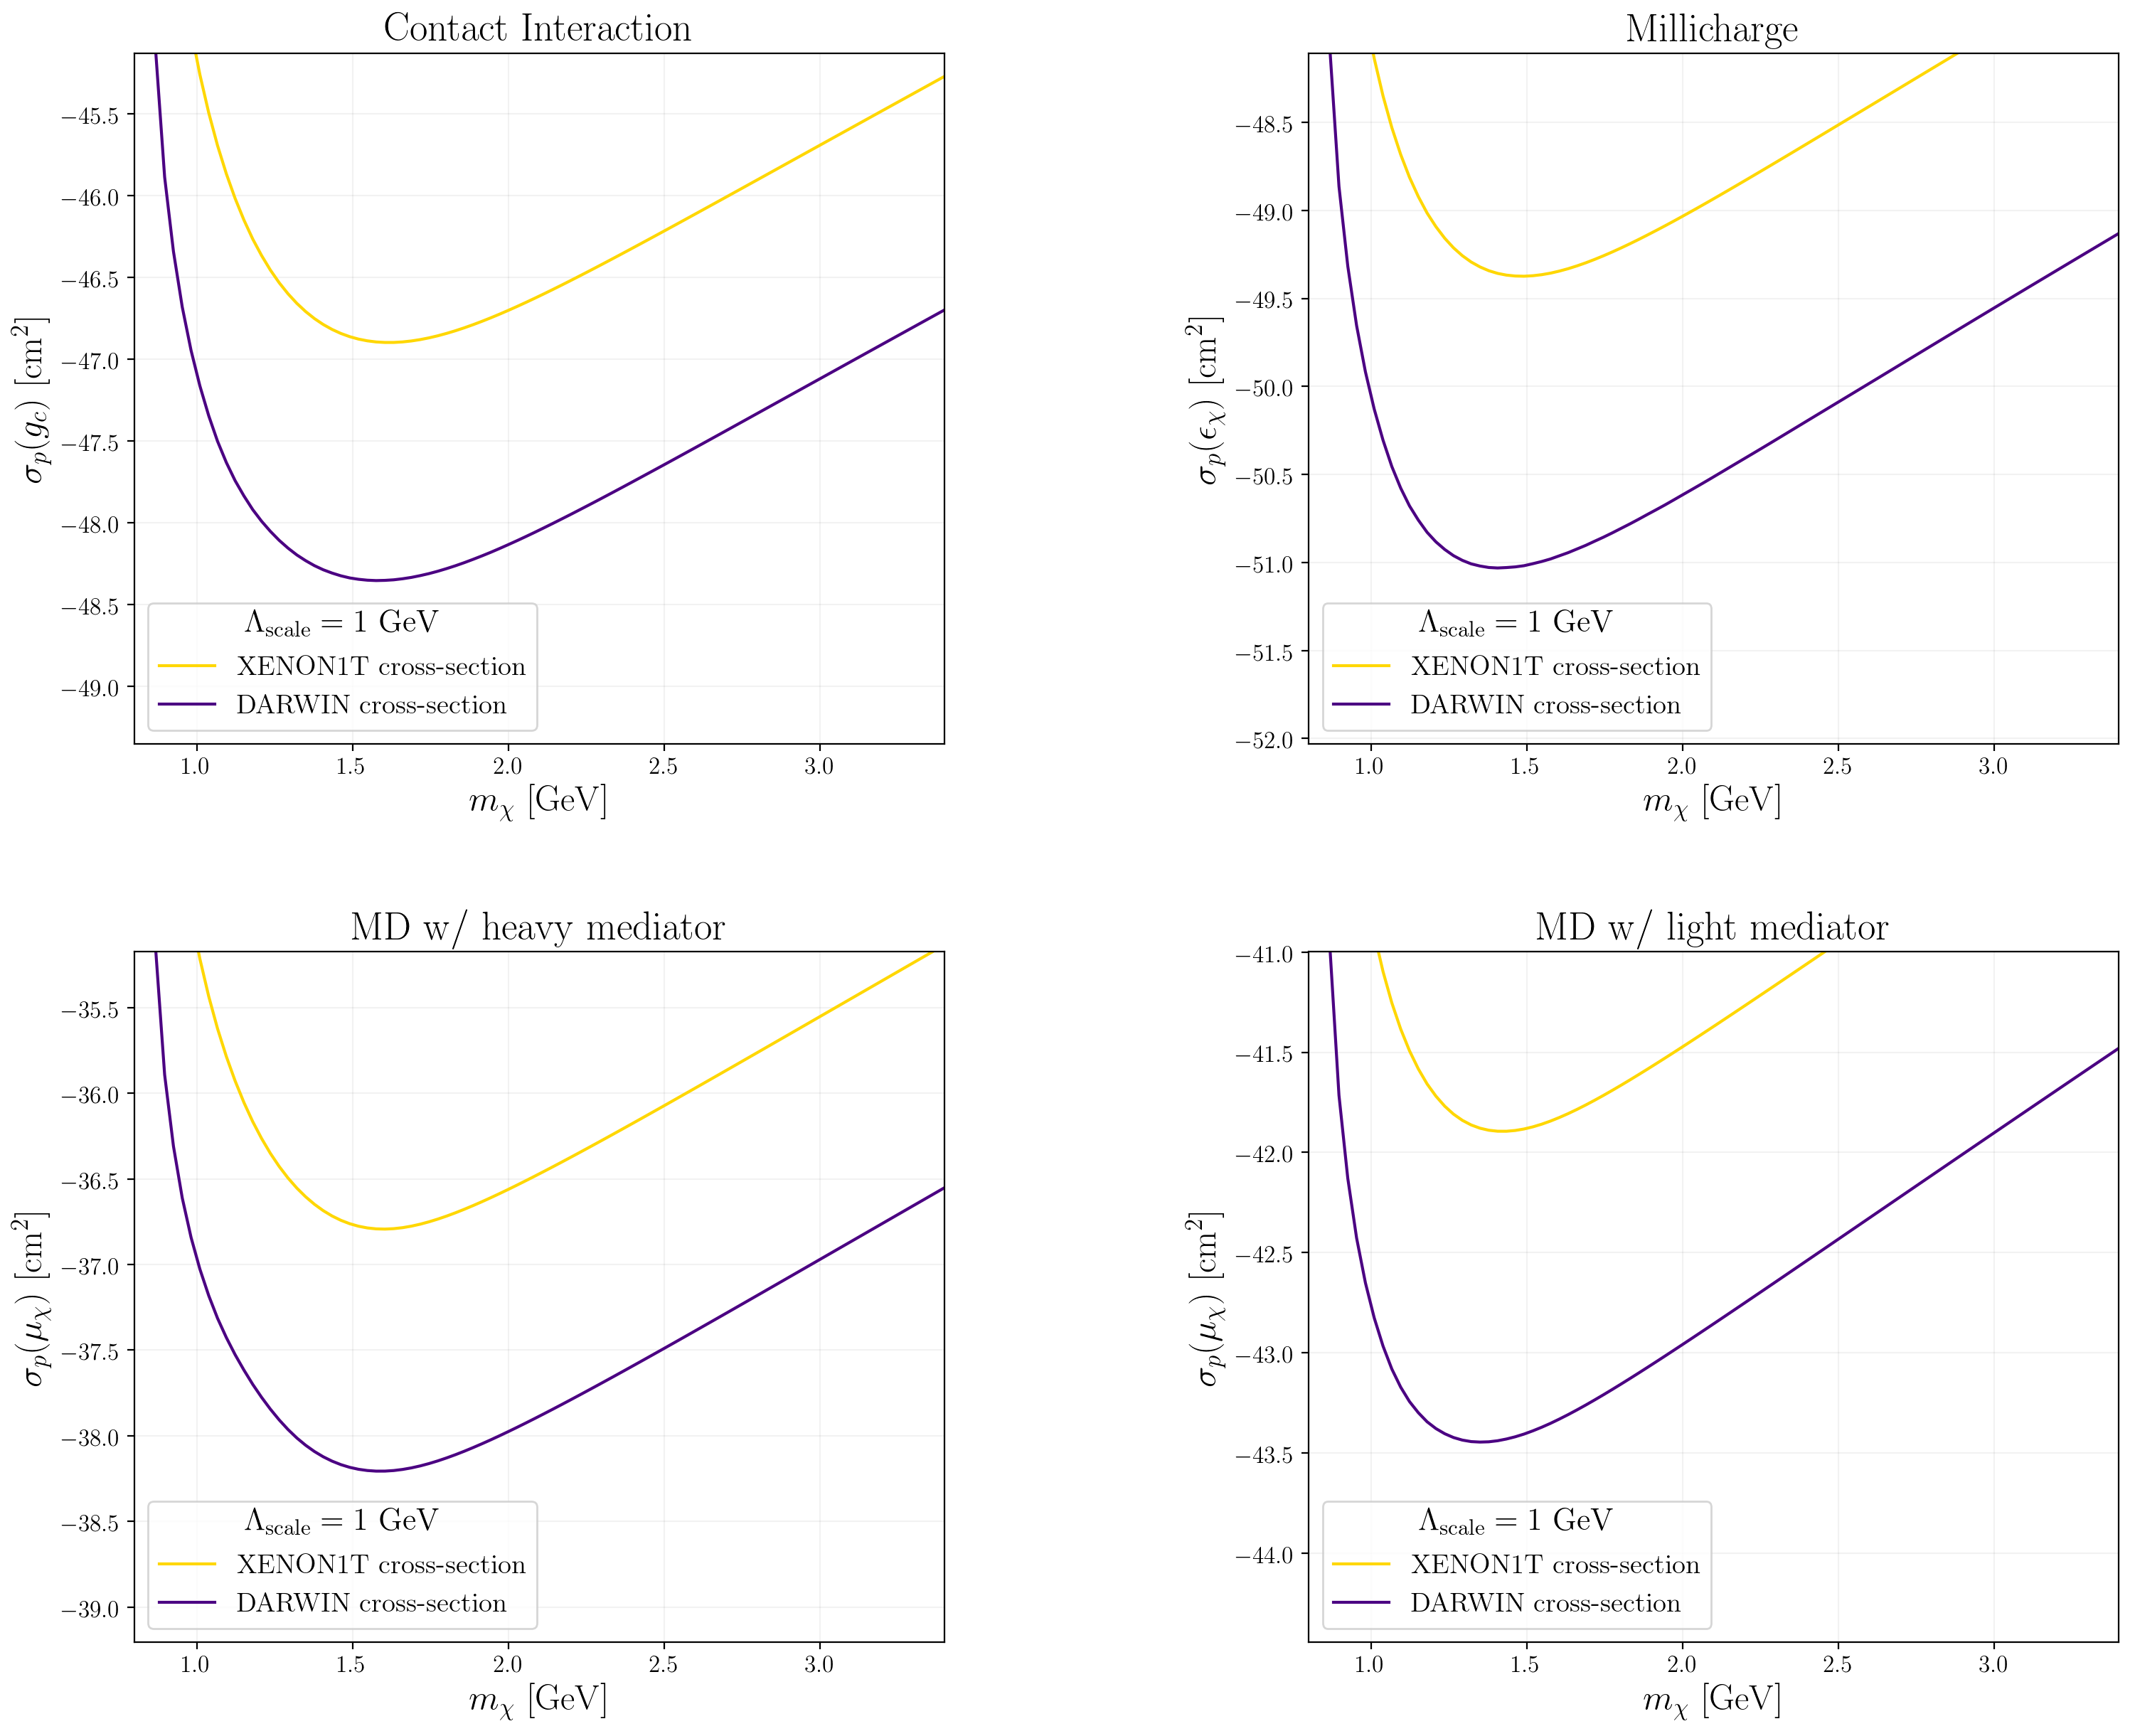

In [71]:
plt.rcParams["figure.figsize"] = (18, 3.7*len(ops_list))
fig, ax= plt.subplots( int(np.ceil(len(ops_list)/2.)) , 2)
fig.subplots_adjust(wspace=0.45, hspace=0.3)

oper_name_list = [r'${\rm Contact\ Interaction}$', r'${\rm Millicharge}$',
                      r'${\rm MD\ w/\ heavy\ mediator}$', r'${\rm MD\ w/\ light\ mediator}$']
unit_name_list = [r'$\sigma_p(g_c) \ [{\rm cm}^2]$', r'$\sigma_p(\epsilon_\chi) \ [{\rm cm}^2]$', \
                    r'$\sigma_p(\mu_\chi) \ [{\rm cm}^2]$', r'$\sigma_p(\mu_\chi) \ [{\rm cm}^2]$']

log_xsec_grid = np.linspace(-44,-47,100)
log_mDM_grid= np.linspace(np.log10(min_mass), np.log10(max_mass), 100)
grid_xsec_official_h1 = []

for i_op, opers in enumerate(ops_list):
    row_indx = np.divide(i_op, 2); col_indx = np.mod(i_op, 2)
    plot_array = []; row_indx = np.divide(i_op, 2); col_indx = np.mod(i_op, 2)

    plot_contours, plot_mass = EC_upper_limit(ER_grid, log_mDM_grid, opers, 'Xenon_1T', 'SHM')
    plot_log_mass = np.log10(plot_mass);  plot_log_contours = xsec_func(np.log10(plot_contours), plot_log_mass ) ; 
    
    plot_contours = xsec_func(np.log10(plot_contours), np.log10(plot_mass) )
    ax[row_indx, col_indx].plot(plot_log_mass, plot_log_contours, color=excl_1T_color, linestyle='solid', label=r'${\rm XENON1T\ cross}$-${\rm section}$')

    plot_contours, plot_mass = EC_upper_limit(ER_grid, log_mDM_grid, opers, 'Xenon_Darwin', 'SHM')
    plot_log_mass = np.log10(plot_mass);  plot_log_contours = xsec_func(np.log10(plot_contours), plot_log_mass ) ; 
    
    ax[row_indx, col_indx].plot(plot_log_mass, plot_log_contours, color=excl_Da_color, linestyle='solid', label=r'${\rm DARWIN\ cross}$-${\rm section}$')

    #plt.clabel(CS, inline=20, fontsize=15)
    #line2, = plt.plot([0], [0], color='black', label = 'This Work')
    ax[row_indx, col_indx].set_xlim((0.8, 3.4))
    ax[row_indx, col_indx].set_ylim( (min(plot_log_contours)-1.0, max(plot_log_contours)) )
    ax[row_indx, col_indx].set_xlabel(r'$m_\chi\ [{\rm GeV}]$', fontsize=18);
    ax[row_indx, col_indx].set_ylabel(unit_name_list[i_op], fontsize=18); 
    the_legend = ax[row_indx, col_indx].legend(title=r'$\Lambda_{\rm scale} = 1 {\rm \ GeV}$', fontsize=14)
    the_legend.get_title().set_fontsize('16')
    ax[row_indx, col_indx].set_title(oper_name_list[i_op], fontsize=20)
    ax[row_indx, col_indx].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-')
    ax[row_indx, col_indx].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-')
    plt.setp(ax[row_indx, col_indx].get_yticklabels()[0], visible=False)
plt.show()

# Mass-coupling constraints and signals

Define the models to plot, the experiment, the $E_R$ grid and the background in recoil energy.

In [66]:
ops_list = ['SS', 'mDM_h', 'mQ','eDM_l']
the_experiment = 'Xenon_Darwin'

ER_grid = np.linspace(5.,40.,80)
dER = ER_grid[1] - ER_grid[0]

event_list = np.zeros_like(ER_grid)
mlist = np.linspace(0.8, 3.5, 200)

exposure = np.ones_like(ER_grid)*exposure_func(the_experiment)
B_null = np.ones_like(ER_grid)*1e-30
B_bkg = bkg_ER(ER_grid)
SF = sf.Swordfish([B_bkg + B_null], E=exposure)

Generate the signal contours.

In [67]:
couplings_list = [] ; mass_list = [] ; ES_list = []
couplings_NLB_list = [] ; mass_NLB_list = [] ; ES_NLB_list = []
cm_list = []; cm_NLB_list = []
sh_list = []; sh_NLB_list = []

for i_op, opers in enumerate(ops_list):
    low_sigma, high_sigma = operators.get_xsec_lim(opers)
    s10list = np.linspace(low_sigma, high_sigma, 200)
    
    rate = lambda mDM, coup: dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'SHM')
    rate_NLB = lambda mDM, coup, eta_sub: dRT_dER_Model(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_full')
    if opers[0] == 'h' or opers[0] == 'l':
        rate = lambda mDM, coup: dRT_dER(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'SHM')
        rate_NLB = lambda mDM, coup: dRT_dER(ER_grid, mDM, coup, opers, experiment=the_experiment, acceptance=True, v_funct = 'NLB_full') 

    signal = lambda m, c: np.abs(rate(10**m, 10**c)*dER)
    signal_NLB = lambda m, c: np.abs(rate_NLB(10**m, 10**c, 0.42)*dER)

    couplings_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing " + opers) ):
        for j, c in enumerate(s10list):
            couplings_temp.append(c)
            mass_temp.append(m)
            dRdER = signal(m, c)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    couplings_list.append( np.array(couplings_temp) )
    mass_list.append( np.array(mass_temp) )
    ES_list.append( np.array(ES_temp) )

    cm = np.zeros([ np.array(couplings_temp).shape[0], 1+1])
    cm[:,0] = np.array( mass_temp )
    cm[:,1] = np.array( couplings_temp )
    
    cm_list.append( cm )
    sh_list.append( sf.SignalHandler( cm, np.array(ES_temp) ) )
    
    couplings_temp = []; mass_temp = []; ES_temp = [];
    for m in tqdm(mlist, desc=("Euclideanizing " + opers) ):
        for j, c in enumerate(s10list):
            couplings_temp.append(c)
            mass_temp.append(m)
            dRdER = signal_NLB(m, c)
            if np.sum(dRdER)==0:
                continue
            ES_temp.append(SF.euclideanizedsignal(dRdER))

    couplings_NLB_list.append( np.array(couplings_temp) )
    mass_NLB_list.append( np.array(mass_temp) )
    ES_NLB_list.append( np.array(ES_temp) )

    cm = np.zeros([np.array(couplings_temp).shape[0], 1+1])
    cm[:,0] = np.array( mass_temp )
    cm[:,1] = np.array( couplings_temp )

    cm_NLB_list.append( cm )
    sh_NLB_list.append( sf.SignalHandler(cm, np.array(ES_temp) ) )

Euclideanizing eDM_l: 100%|██████████| 200/200 [13:45<00:00,  4.13s/it]


### Result

We plot the two signal benchmark points for four DM models in mass-coupling plane. We shows both the _Gaia_ and SHM contours, as well as the constraints for references. The solid lines represent the rate under _Gaia_ astrophysics and the solid lines under SHM. Yellow lines are the XENON1T upper limits with 1 ton year exposure, purple are the projected DARWIN upper limits with 200 ton year exposure. The orange and cyan are the signal contours for _Gaia_ and SHM respectively.

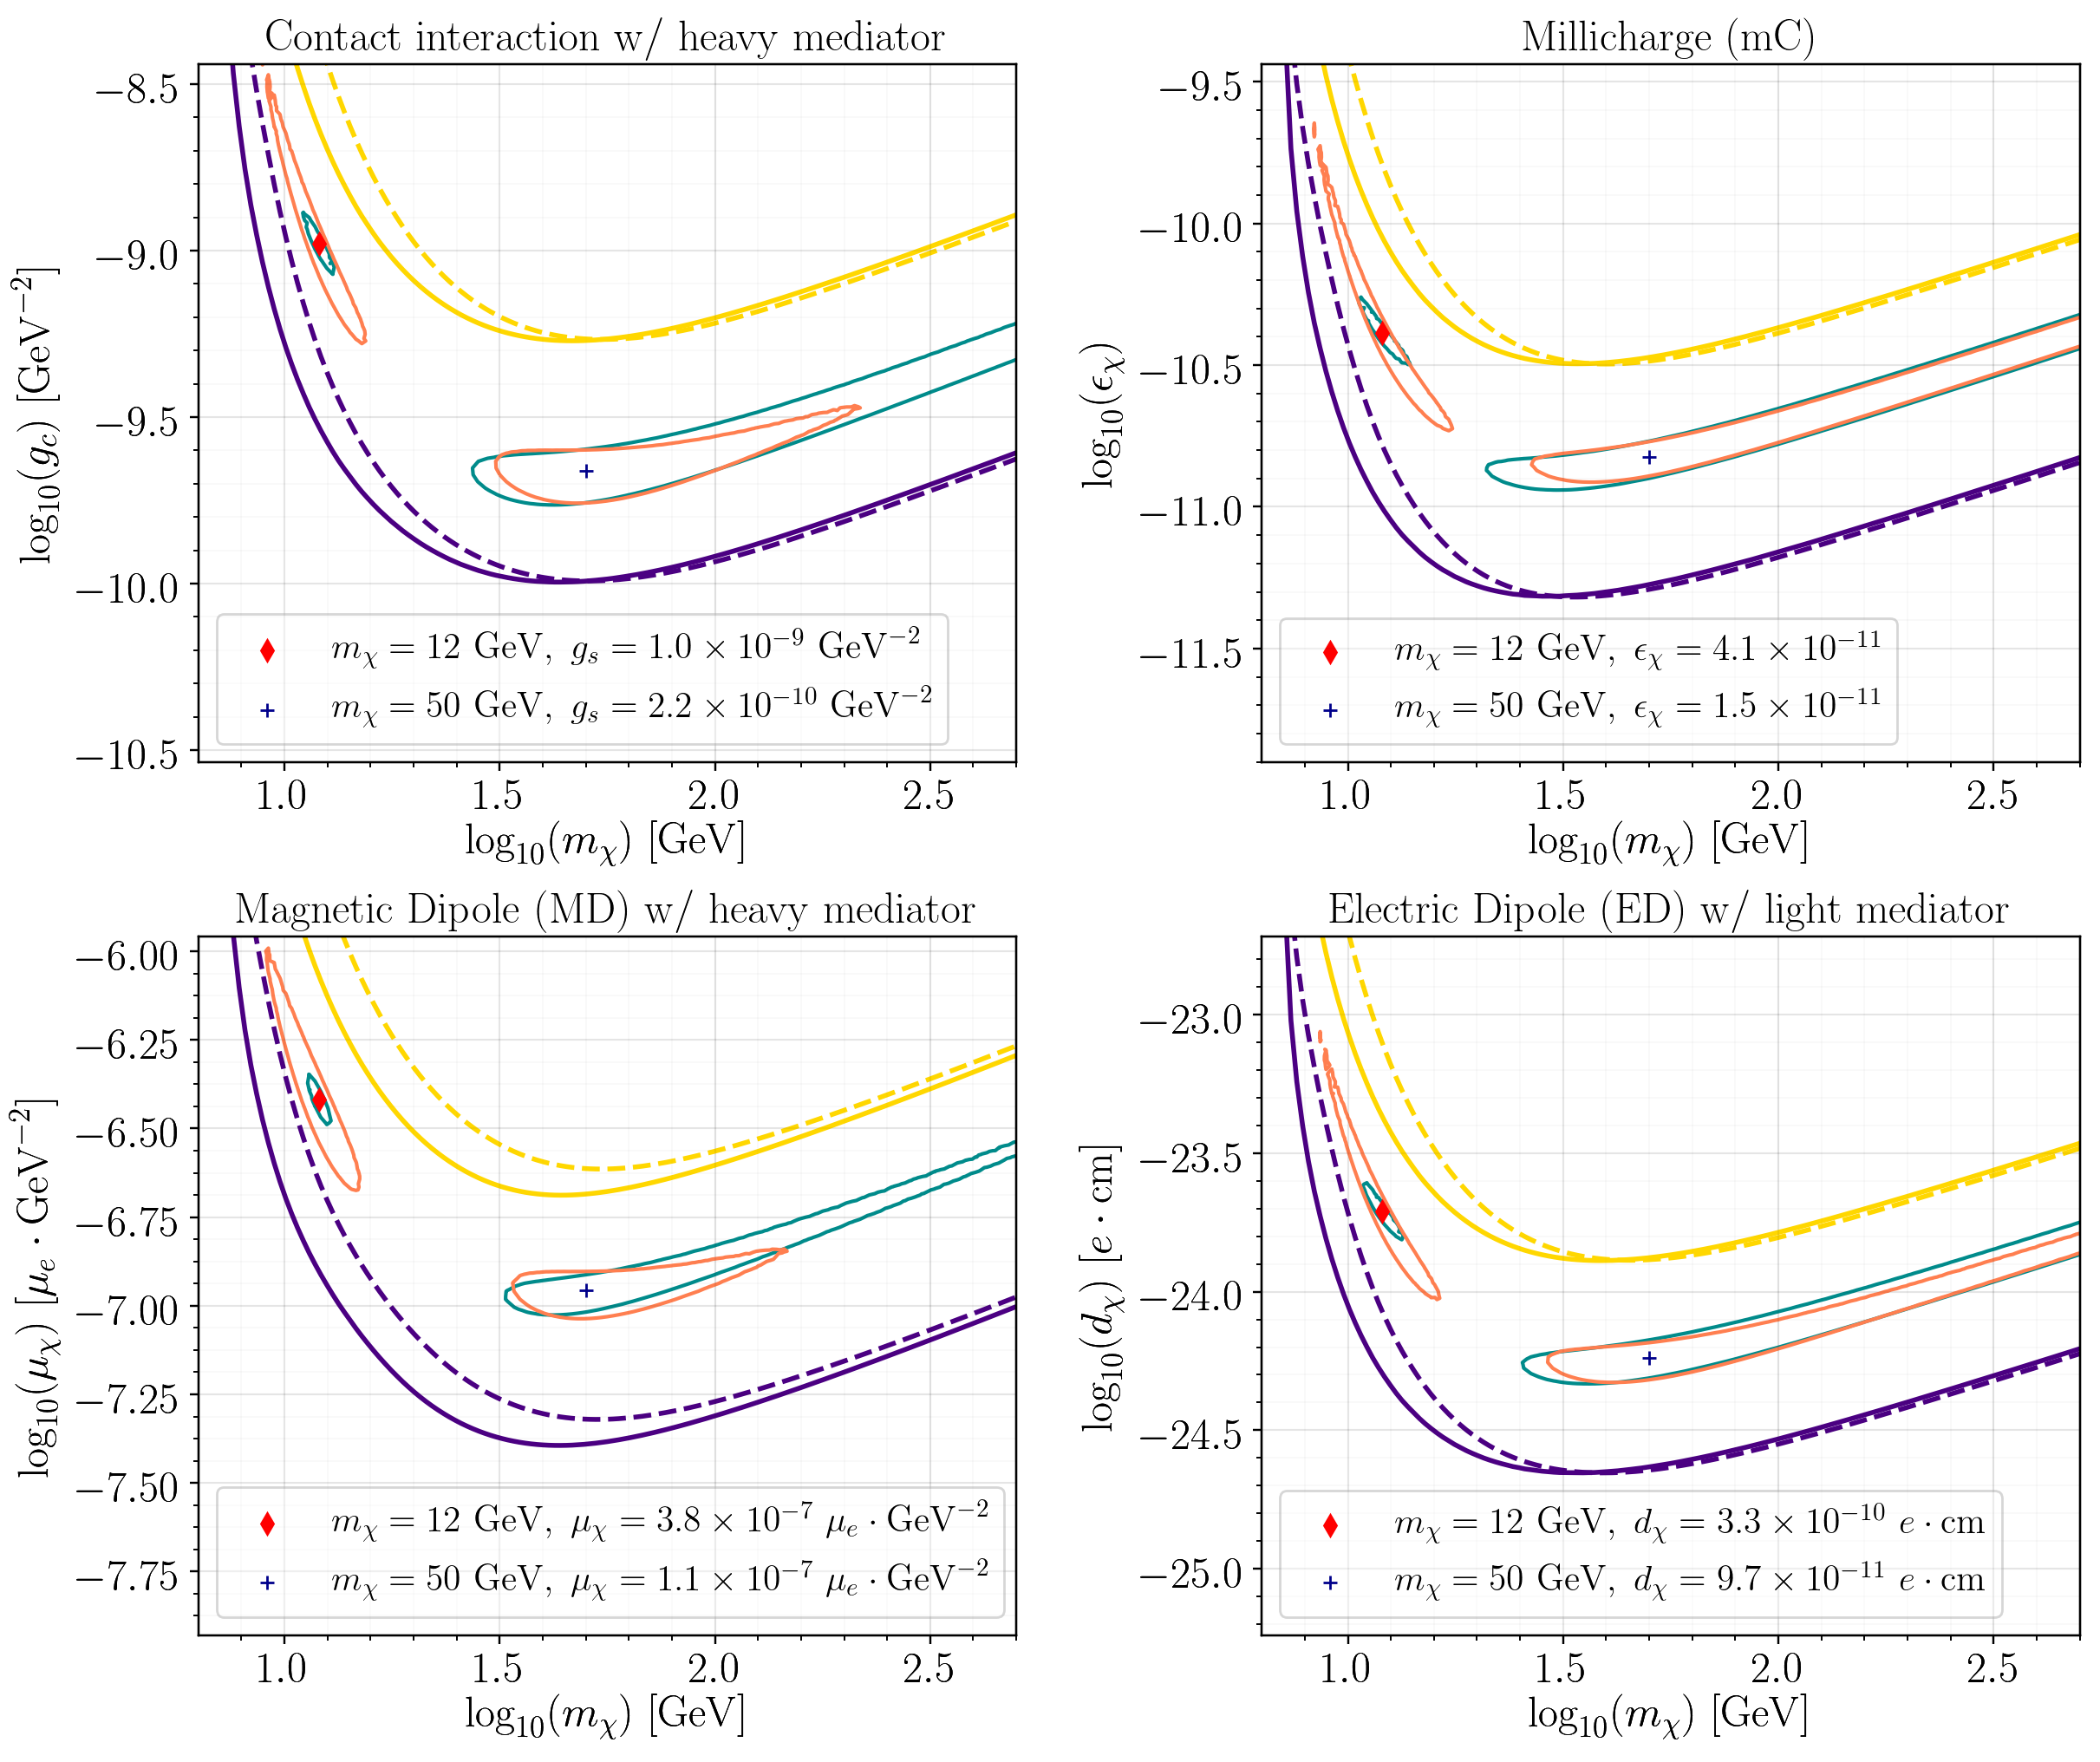

In [69]:
ops_list = ['SS', 'mDM_h', 'mQ','eDM_l']


marker_list = ['d','+']; color_list = ['red','darkblue']
coupling_names = [r'g_s', r'\mu_\chi', r'\epsilon_\chi', r'd_\chi']
units = [r'{\rm GeV}^{-2}', r'\mu_e\cdot{\rm GeV}^{-2}', r'\ ', r'e\cdot{\rm cm}']
name_list = [r'${\rm Contact\ interaction\ w/\ heavy\ mediator}$', r'${\rm Magnetic\ Dipole\ (MD)\ w/\ heavy\ mediator}$', \
            r'${\rm Millicharge\ (mC)}$', r'${\rm Electric\ Dipole\ (ED)\ w/\ light\ mediator}$']

plt.rcParams["figure.figsize"] = (14, 3.*len(ops_list))
fig, ax = plt.subplots( int(np.ceil(len(ops_list)/2.)) , 2)
fig.subplots_adjust(wspace=0.3, hspace=0.25)


def get_signal_points(sig_list_1, sig_list_2, mask=None):
    pt_1 = [sig_list_1[0], sig_list_2[0]]
    pt_2 = [sig_list_1[1], sig_list_2[1]]
    signal_pts = np.array([pt_1, pt_2])
    if mask is not None:
        return signal_pts[mask]
    return signal_pts

mass_pt = [1.08, 1.7]

SS_list = [-8.98, -9.662];
mQ_list = [-10.386, -10.824];
de_l_list = [-9.487, -10.015];
mu_h_list = [-3.947, -4.485];

ana_h_list = [-5.024, -5.775]
ana_l_list = [-7.858, -8.381]
de_h_list = [-6.673, -7.531]
mu_l_list = [-6.750, -7.091]


cm_plot_list = [ get_signal_points(mass_pt, SS_list), \
                get_signal_points(mass_pt, mu_h_list),
                get_signal_points(mass_pt, mQ_list), \
                get_signal_points(mass_pt, de_l_list) ]

xaxsec_list = []; yaxsec_list = []

for i_op, opers in enumerate(ops_list):
    row_indx = np.divide(i_op, 2);
    col_indx = np.mod(i_op, 2)
    
    cm_plot = cm_plot_list[i_op]
    sh = sh_list[i_op]; sh_NLB = sh_NLB_list[i_op]
    mass = mass_list[i_op]; mass_NLB = mass_NLB_list[i_op]
    couplings = couplings_list[i_op] ; couplings_NLB = couplings_NLB_list[i_op]
       
    for j_p, P0 in enumerate(cm_plot):
        if opers[:3] == 'eDM':
            cal_coup = elc_moment(P0[1], log_coup = True, log_out = True)
        if opers[:3] == 'mDM':
            cal_coup = mag_moment(P0[1], log_coup = True, log_out = True)
        else:
            cal_coup = P0[1]
        pow_coup = int(cal_coup-1); dig_coup = (cal_coup - pow_coup)
        pt_desc = r'$m_\chi = %i \ {\rm GeV},\ %s = %.1f \times 10^{%i} \ %s $'% (int(10**P0[0]), coupling_names[i_op], 10**dig_coup, pow_coup, units[i_op])
        ax[col_indx,row_indx].plot(P0[0], P0[1], marker=marker_list[j_p], color=color_list[j_p], linestyle = 'None', label=pt_desc)
        plot_ellipse(ax[col_indx,row_indx], sh, mass, couplings, P0, 'SHM')
        plot_ellipse(ax[col_indx,row_indx], sh_NLB, mass_NLB, couplings_NLB, P0, 'NLB')
        
    log_mass_list = np.linspace(min(mlist), max(mlist), 300)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_1T', 'SHM')
    ax[col_indx,row_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_1T_color, linestyle=SHM_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_Darwin', 'NLB_full')
    ax[col_indx,row_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_Da_color, linestyle=Gaia_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_Darwin', 'SHM')
    ax[col_indx,row_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_Da_color, linestyle=SHM_excl_style, linewidth=2)
    plot_contours, plot_mass = EC_upper_limit(ER_grid, mlist, opers, 'Xenon_1T', 'NLB_full')
    ax[col_indx,row_indx].plot(np.log10(plot_mass), np.log10(plot_contours), color=excl_1T_color, linestyle=Gaia_excl_style, linewidth=2)
 
    ax[col_indx,row_indx].legend(loc='lower left', frameon=True, fontsize=15)
    xlim_d, xlim_u = ax[col_indx,row_indx].get_xlim(); ax[col_indx,row_indx].set_xlim((0.8, 2.7))
    if row_indx == 0:
        ylim_d, ylim_u = ax[col_indx,row_indx].get_ylim(); ax[col_indx,row_indx].set_ylim((ylim_d-0.3, ylim_u-3.5))
    else:
        ylim_d, ylim_u = ax[col_indx,row_indx].get_ylim(); ax[col_indx,row_indx].set_ylim((ylim_d-0.35, ylim_u-3.))
    format_fig(ax[col_indx,row_indx], 'mass', opers, None, r'$\log_{10}(g_{c})\ [\rm{GeV}^{-2}]$', log_log_in = True, log_log_out = True)
    ax[col_indx,row_indx].set_title(name_list[i_op], fontsize=18)
    
plt.show()